# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Общая информация о файле

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv("/datasets/real_estate_data.csv", sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


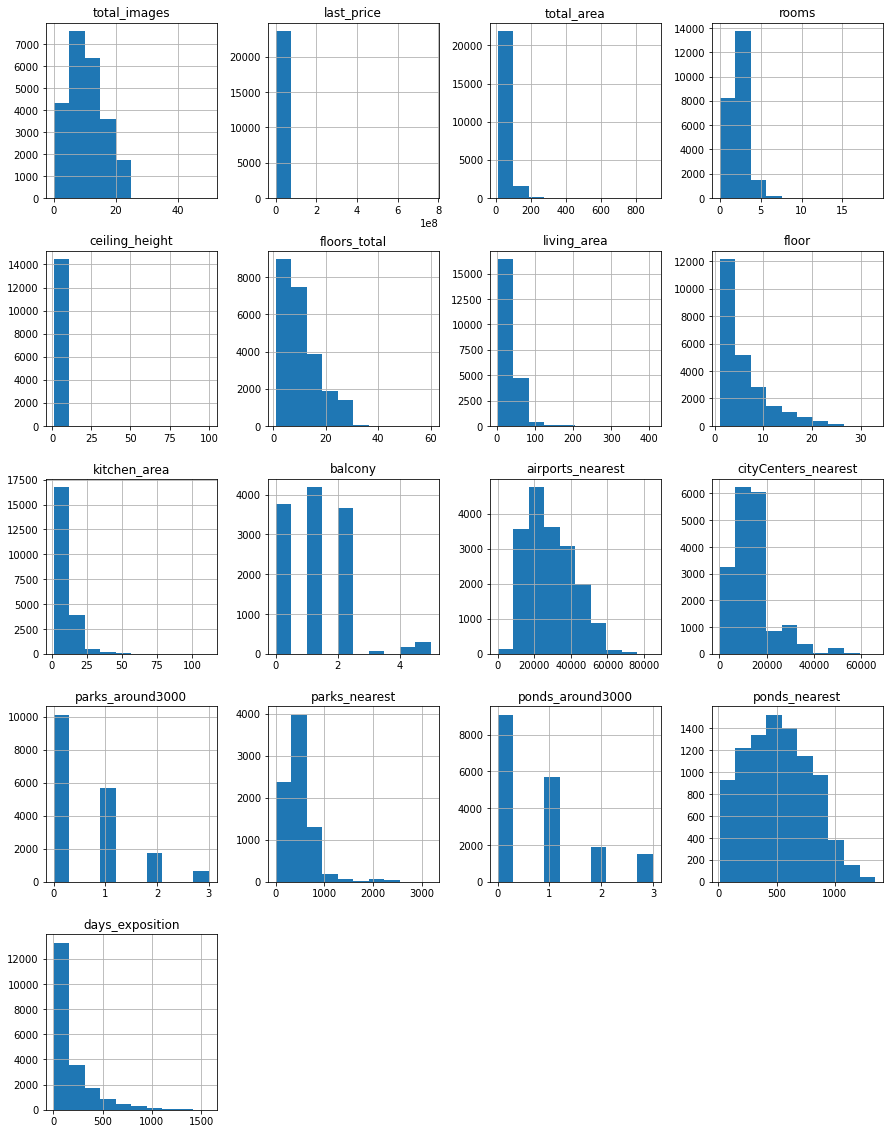

In [4]:
data.hist(figsize=(15, 20))
plt.show()

### Предобработка данных

In [5]:
data.isna().sum().sort_values()

total_images                0
open_plan                   0
floor                       0
rooms                       0
studio                      0
total_area                  0
last_price                  0
first_day_exposition        0
locality_name              49
floors_total               86
living_area              1903
kitchen_area             2278
days_exposition          3181
ponds_around3000         5518
parks_around3000         5518
cityCenters_nearest      5519
airports_nearest         5542
ceiling_height           9195
balcony                 11519
ponds_nearest           14589
parks_nearest           15620
is_apartment            20924
dtype: int64

In [6]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок городского типа', 'деревня'], 'поселок', regex=True)
)
data['locality_name'] = data['locality_name'].replace('поселок Шушары', 'Шушары', regex=True)
data['locality_name'] = data['locality_name'].replace('поселок Мурино', 'Мурино', regex=True)
data['locality_name'] = data['locality_name'].replace('поселок Кудрово', 'Кудрово', regex=True)
data = data.dropna(subset=['locality_name'])
data.duplicated().sum()

0

In [7]:
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['days_exposition'] = data['days_exposition'].fillna(0)
data['airports_nearest'] = data.groupby('locality_name')['airports_nearest'].transform(lambda x: x.fillna(x.median()) if x.notna().any() else x)

data['is_apartment'] = data['is_apartment'].fillna(False)
data['total_area'] = data.groupby('rooms')['total_area'].transform(lambda x: x.fillna(x.median()))
data['living_area'] = data.groupby('rooms')['living_area'].transform(lambda x: x.fillna(x.median()))
data['kitchen_area'] = data.groupby('rooms')['kitchen_area'].transform(lambda x: x.fillna(x.median()))

data.isna().sum().sort_values()

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


total_images                0
ponds_around3000            0
parks_around3000            0
locality_name               0
balcony                     0
open_plan                   0
is_apartment                0
floor                       0
studio                      0
rooms                       0
first_day_exposition        0
total_area                  0
last_price                  0
living_area                 0
days_exposition             0
floors_total               85
kitchen_area              197
airports_nearest         4829
cityCenters_nearest      5511
ceiling_height           9160
ponds_nearest           14565
parks_nearest           15586
dtype: int64

В столбцах floors_total, balcony, is_apartment, locality_name пользователь, скорее всего, не указал данные, поэтому появились пропуски. В столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest произошла какая-то техническая ошибка (в некотрых столбцах я заменил nan нулём, чтобы не возникало проблем при изменении типа данных).

In [8]:
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")
data['last_price'] = data['last_price'].astype('int')
data['last_price'].astype('int')

0        13000000
1         3350000
2         5196000
3        64900000
4        10000000
           ...   
23694     9700000
23695     3100000
23696     2500000
23697    11475000
23698     1350000
Name: last_price, Length: 23650, dtype: int64

Столбцы balcony, parks_around3000, ponds_around3000, days_exposition, last_price были приведены к типу int, потому что эти столбцы предназначены для целочисленных значений (например, не может быть 1.5 балкона, или 2.64 парка рядом). Столбец first_day_exposition был приведён к типу данных datetime. 

### Добавление новых столбцов

In [9]:
data['price_for_meter'] = (data['last_price'] / data['total_area']).round(2)

In [10]:
data['day_of_exposition'] = data['first_day_exposition'].dt.dayofweek
data['month_of_exposition'] = data['first_day_exposition'].dt.month
data['year_of_exposition'] = data['first_day_exposition'].dt.year

In [11]:
def floor_type(row):
        if row['floor'] == 1:
            return 'Первый'
        if row['floor'] == row['floors_total']:
            return 'Последний'
        return 'Другой'
               
data['floor_type'] = data.apply(floor_type, axis = 1)

In [12]:
data['centre_distance'] = (data['cityCenters_nearest'] / 1000).round()

### Исследовательский анализ данных

#### Общая площадь

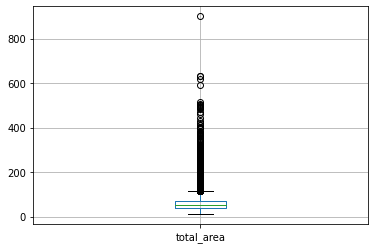

In [13]:
data.boxplot('total_area');

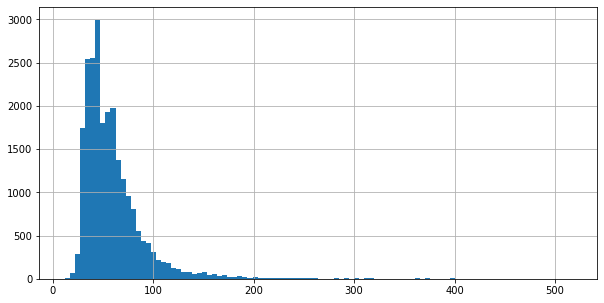

In [14]:
data = data[(((data['total_area']) > (data['living_area'])) & (data['total_area'] < 550)) | (data['total_area'].isna())]
data['total_area'].hist(figsize=(10, 5), bins=100);

В данных были строчки, в которых общая площадь была меньше жилой площади. Также были очень сильно выбивающиеся значение, например: общая площадь 900 м^2. Больше всего квартир площадью примерно 45 кв.м.

#### Жилая площадь

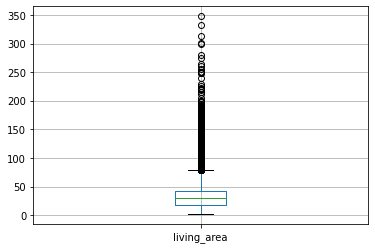

In [15]:
data.boxplot('living_area');

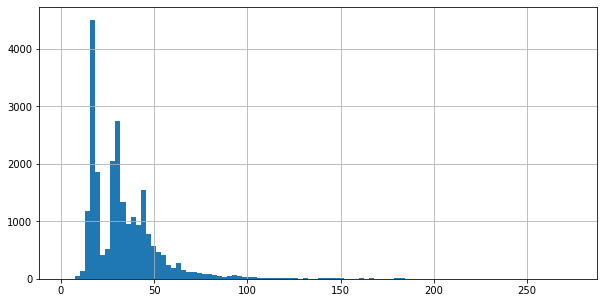

In [16]:
data = data[(data['living_area'] < 275) | (data['living_area'].isna())]
data['living_area'].hist(figsize=(10, 5), bins=100);

На этой гисторамме видна некая "впадина" в значениях. Наблюдается два пика: примерно 18 и 30 кв.м. Были удалены редкие значения больше 275.

#### Площадь кухни

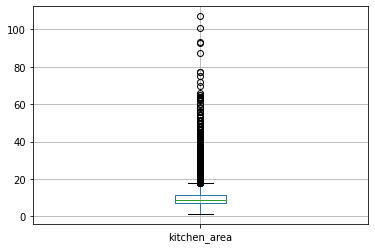

In [17]:
data.boxplot('kitchen_area');

<AxesSubplot:>

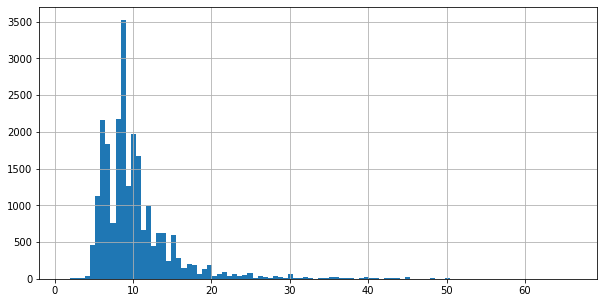

In [18]:
data = data[(data['kitchen_area'] < 70) | (data['kitchen_area'].isna())]
data['kitchen_area'].hist(figsize=(10, 5), bins=100)

На этой гистограмме наблюдается множество пиков. Больше всего кухонь площадью примерно 8 кв.м. Были удалены редкие значения больше 40.

#### Цена объекта

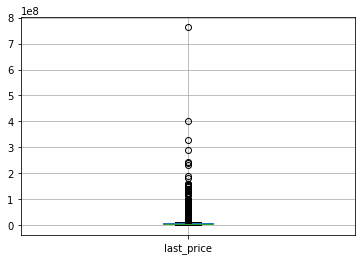

In [19]:
data.boxplot('last_price');

<AxesSubplot:>

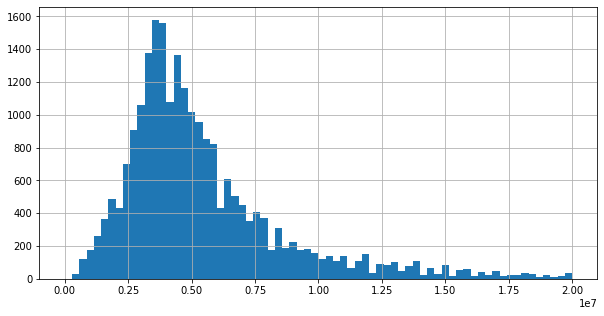

In [20]:
data = data[((data['last_price'] < 2*10**8) & (data['last_price'] != 12190)) | (data['last_price'].isna())]
data['last_price'].hist(figsize=(10, 5), bins=70, range=(0, 20000000))

В основном цены лежат в диапазоне от 2500000 до 5000000 рублей

#### Комнаты

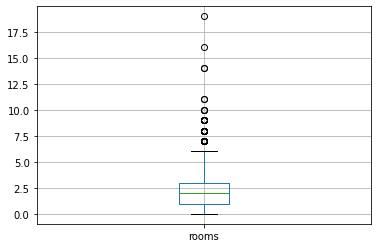

In [21]:
data.boxplot('rooms');

<AxesSubplot:>

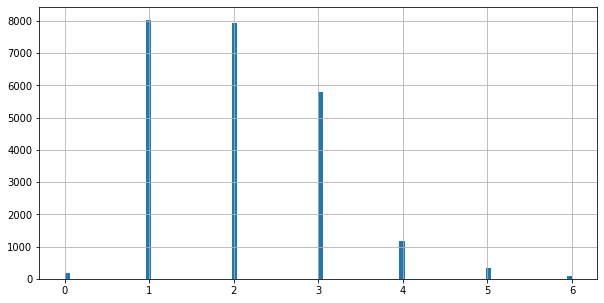

In [22]:
data = data[(data['rooms'] < 7) | (data['rooms'].isna())]
data['rooms'].hist(figsize=(10, 5), bins=100)

Больше всего квартир с одной комнатой. Были удалены данные, где комнат было 0. Удалены аномальные значения.

#### Высота потолков

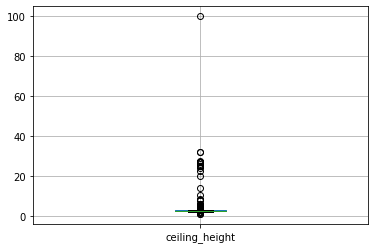

In [23]:
data.boxplot('ceiling_height');

<AxesSubplot:>

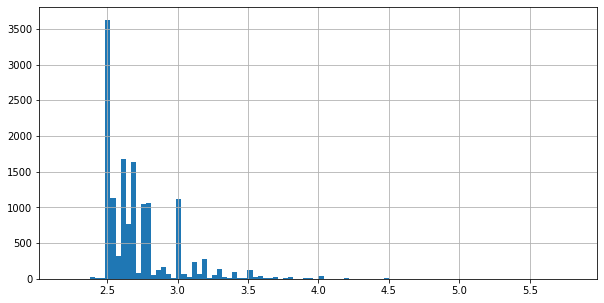

In [24]:
data['ceiling_height'][data['ceiling_height'] > 10] = (data['ceiling_height'][data['ceiling_height'] > 10]) / 10
data = data[((data['ceiling_height'] < 6) & (data['ceiling_height'] > 2)) | (data['ceiling_height'].isna())]
data['ceiling_height'].hist(figsize=(10, 5), bins=100)

Больше всего квартир с высотой потолком 2.5 м. Были изменены неверные значения и удалены аномальные значения.

#### Этаж, на котором находится квартира

<AxesSubplot:>

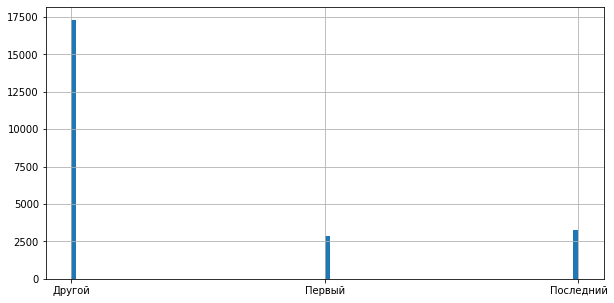

In [25]:
data['floor_type'].hist(figsize=(10, 5), bins=100)

Больше всего квартир находится на втором этаже. Были удалены аномальные значения.

#### Общее количество этажей

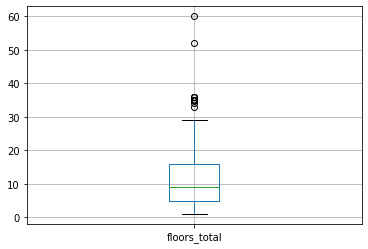

In [26]:
data.boxplot('floors_total');

<AxesSubplot:>

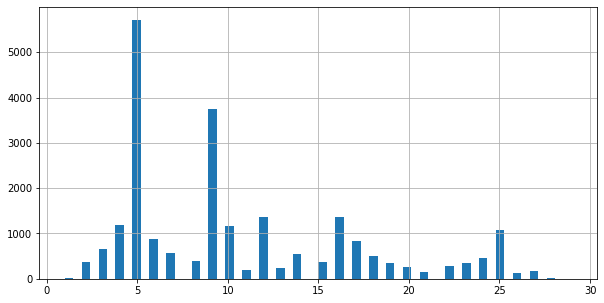

In [27]:
data = data[(data['floors_total'] < 30) | (data['floors_total'].isna())]
data['floors_total'].hist(figsize=(10, 5), bins=60)

Наибольшее количество этажей - 5 и 9. Были удалены редкие значения.

#### Расстояние до центра города

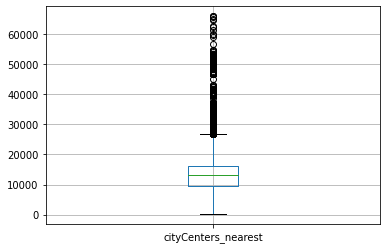

In [28]:
data.boxplot('cityCenters_nearest');

<AxesSubplot:>

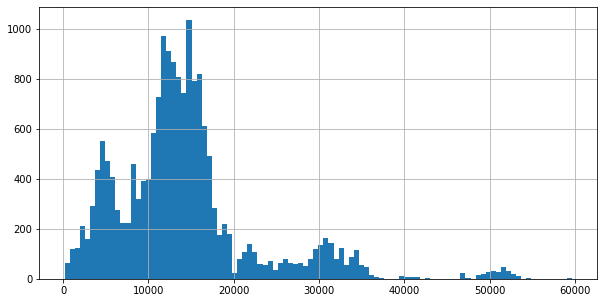

In [29]:
centre_data = data[((data['cityCenters_nearest'] != 0) & (data['cityCenters_nearest'] < 60000)) | (data['cityCenters_nearest'].isna())]
centre_data['cityCenters_nearest'].hist(figsize=(10, 5), bins=100)

Были удалены редкие значения. Наиболее частое расстояние до метро - примерно от 12 до 15 километров. Были исправлены значения на метры.

#### Расстояние до парка

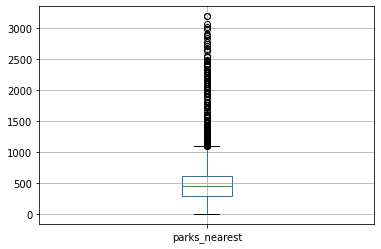

In [30]:
data.boxplot('parks_nearest');

<AxesSubplot:>

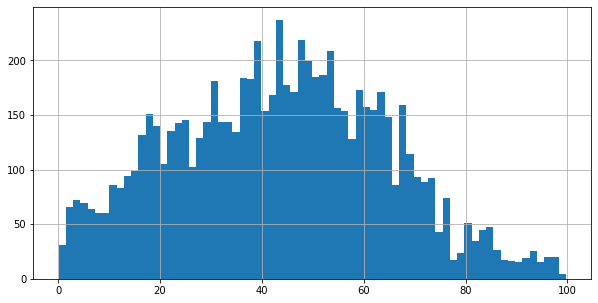

In [31]:
data['parks_nearest'] = data['parks_nearest'] / 10
data = data[((data['parks_nearest'] != 0) & (data['parks_nearest'] < 100)) | (data['parks_nearest'].isna())]
data['parks_nearest'].hist(figsize=(10, 5), bins=70)

Были удалены аномальные значения. Наиболее частое расстояние до парков - примерно от 40 до 50 метров. Были исправлены значения на метры.

#### Скорость продажи квартиры

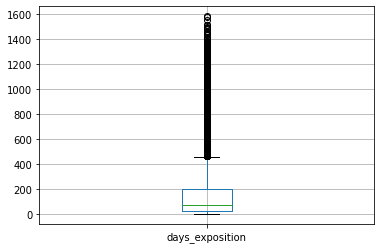

In [32]:
data.boxplot('days_exposition');

<AxesSubplot:>

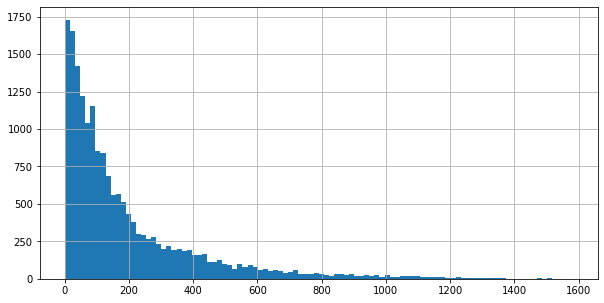

In [33]:
good_data = data[((data['days_exposition'] != 0) & (data['days_exposition'] != 60) & (data['days_exposition'] != 45) & (data['days_exposition'] != 30) & (data['days_exposition'] != 7)) | (data['days_exposition'].isna())]
good_data['days_exposition'].hist(figsize=(10, 5), bins=100)

In [34]:
print(data['days_exposition'].mean())
data['days_exposition'].median()

155.7553832156319


73.0

In [35]:
print(data['days_exposition'].quantile(0.75))
data['days_exposition'].quantile(0.25)

197.0


22.0

Продажи обычно занимают от 22 до 197 дней. Быстрыми продажами можно считать всё, что меньше 22 дня, а медленными - больше 197 дней.

#### Влияние факторов на полную стоимость объекта.

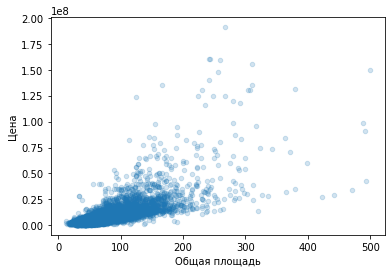

In [36]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.2, xlabel='Общая площадь', ylabel='Цена')
plt.show()

С увеличением площади увеличивается цена.

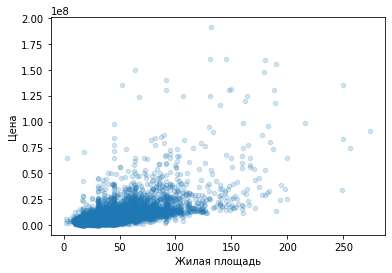

In [37]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.2, xlabel='Жилая площадь', ylabel='Цена')
plt.show()

С увеличением площади увеличивается цена.

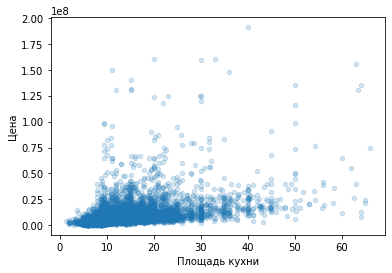

In [38]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.2, xlabel='Площадь кухни', ylabel='Цена')
plt.show()

С увеличением площади увеличивается цена.

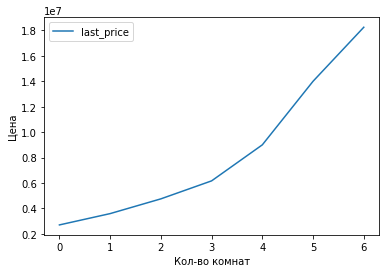

In [39]:
room_price = data.pivot_table(index='rooms', values='last_price', aggfunc='median')
room_price.plot(xlabel='Кол-во комнат', ylabel='Цена');

Чем больше комнат, тем выше цена.

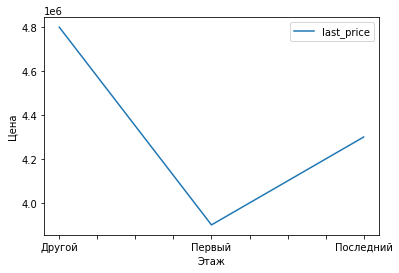

In [40]:
floor_data = data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
floor_data.plot(xlabel='Этаж', ylabel='Цена');

Дешевле всего квартиры на первом этаже, дороже - на других этажах (не первом и последнем)

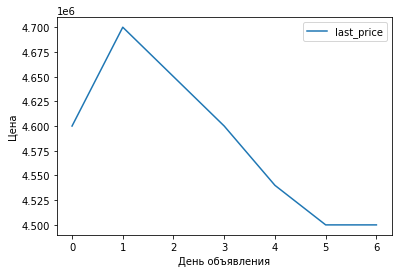

In [41]:
day_data = data.pivot_table(index='day_of_exposition', values='last_price', aggfunc='median')
day_data.plot(xlabel='День объявления', ylabel='Цена');

Квартиры подороже продаются по вторникам и среднем. Самые дешёвые квартиры продаются по субботам.

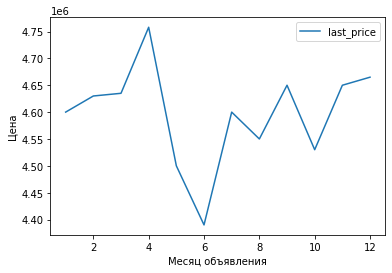

In [42]:
month_data = data.pivot_table(index='month_of_exposition', values='last_price', aggfunc='median')
month_data.plot(xlabel='Месяц объявления', ylabel='Цена');

В декабре была продана самая дорогая квартира, на втором месте по продаже дорогих квартир находится апрель. В июне продана самая дешёвая квартира.

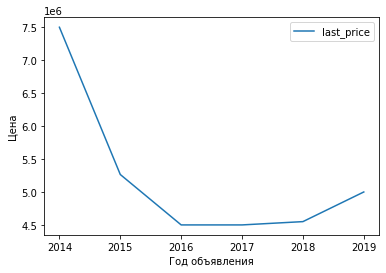

In [43]:
year_data = data.pivot_table(index='year_of_exposition', values='last_price', aggfunc='median')
year_data.plot(xlabel='Год объявления', ylabel='Цена');

В 2014 была продана самая дорогая квартира. В последующие годы цена самой дорогой квартиры, проданной в году пошла на спад, но начала возрастать в 2018.

In [44]:
table = data.pivot_table(index='locality_name', values='price_for_meter', aggfunc=['mean', 'count'])
table.columns = ['mean_price', 'amount_of_ads']
sorted_table = table.sort_values(by='amount_of_ads', ascending=False).head(10)
sorted_table.sort_values(by='mean_price', ascending=False)

,mean_price,amount_of_ads
locality_name,,
Санкт-Петербург,113703.915174,15208
Пушкин,103100.890978,368
Кудрово,95326.179108,471
поселок Парголово,90332.262638,326
Мурино,86074.078251,589
Шушары,78677.364318,440
Колпино,75307.719784,324
Всеволожск,68789.205519,395
Гатчина,68746.146515,307


В приведённых выше таблицах указаны 10 населённых пунктов c наибольшим количеством объявлений, отсортированных по цене.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23081 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23081 non-null  int64         
 1   last_price            23081 non-null  int64         
 2   total_area            23081 non-null  float64       
 3   first_day_exposition  23081 non-null  datetime64[ns]
 4   rooms                 23081 non-null  int64         
 5   ceiling_height        14161 non-null  float64       
 6   floors_total          22999 non-null  float64       
 7   living_area           23081 non-null  float64       
 8   floor                 23081 non-null  int64         
 9   is_apartment          23081 non-null  bool          
 10  studio                23081 non-null  bool          
 11  open_plan             23081 non-null  bool          
 12  kitchen_area          22891 non-null  float64       
 13  balcony         

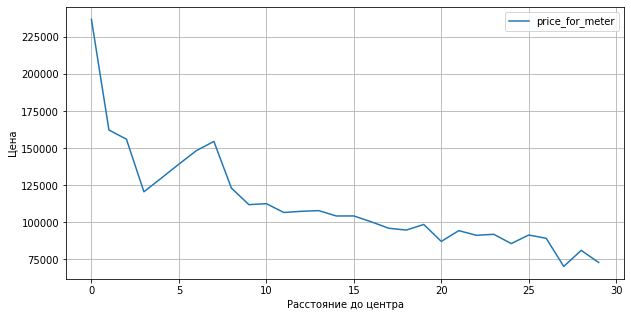

In [45]:
spb_data = data[data['locality_name'] == 'Санкт-Петербург']
good_spb_data = spb_data.pivot_table(index='centre_distance', values='price_for_meter', aggfunc='mean')
good_spb_data.plot(grid=True, figsize=(10, 5), xlabel='Расстояние до центра', ylabel='Цена')
data.info()

Наивысшая цена наблюдается в самом центре. Цена снижается по удалению по центра, с пиком примерно в 7 км от центра.

### Общий вывод

В начале работы мы получили таблицу, состоящую из 23699 строк и 22 столбцов. Обнаружилось, что в таблице есть пропуски данных. Некоторые пропуски, скорее всего появились из-за того, что пользователи не ввели данные, либо из-за какой-то технической ошибки. Некоторые пропуски мы заполнили нулём, чтобы не возникало проблем, при изменении типа данных. Были заменены неявные пропуски в столбце с населёнными пунктами. Мы рассчитали медианные значения площадей по аналогичному количеству комнат и заполнили ими пропуски в данных. Мы добавили новые столбцы в таблицы: цена за квадратный метр, день, месяц, год объявления, тип этажа (первый, последний, другой), расстояние до центра города в километрах. Далее мы удалили аномалии и строили гистограммы для некоторых столбцов. Определили, что обычно квартиры продаются от 22 до 197 дней. Затем мы оценивали влияние некоторых факторов на цену недвижимости (например, с увеличением площади увеличивается цена). Далее мы установили, что, чем ближе недвижимость в Санкт-Петербурге находится к центру, тем больше её цена.

Мы отбросили 618 строк во время предобработки.

В результате исследования мы установили, что на цену недвижомости влияет площадь, этаж, на которой она находится и расстояние до центра.